In [1]:
import logging
from tqdm.auto import tqdm, trange
import os
import random
import numpy as np
from glob import glob
from typing import List, Dict
import pandas as pd
from nltk.parse.corenlp import CoreNLPParser
import inspect
from itertools import cycle
import ast
import itertools
from pathlib import Path
from datetime import datetime
import collections

In [2]:
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast, AutoTokenizer
from transformers import BertForMaskedLM, BertConfig, PreTrainedModel, AutoModel, AutoModelForSequenceClassification
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from transformers import IntervalStrategy
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import get_scheduler
import torch
import wandb
from datasets import Dataset
from sklearn import preprocessing
import evaluate
import transformers
from sklearn.metrics import mean_squared_error, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import top_k_accuracy_score
import datasets
# import matplotlib.pyplot as plt

In [3]:
transformers.__version__

'4.26.0'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [6]:
cols_to_eval = ['edge_indexs', 'hetoro_edges', 'pos_seqs', 'upos_seqs', 'alignments']

In [7]:
def preprocess_author_ids(df, col='author'):
    assert col in df, f'no column named {col} found in df'
    
    unique_author = sorted(df['author'].unique())
    mapping = {unique_author[i]:i for i in range(len(unique_author))}
    df[col] = df[col].map(mapping)
    
    return df

In [8]:
def freeze_model(model, freeze_bert):
    '''
    if freeze_bert is True, freeze all layer. 
    if freeze_bert is a positive integer, freeze the bottom {freeze_bert} attention layers
    negative integer should also work
    '''
    if freeze_bert is True: # == True is wrong!!!
        for param in model.bert.parameters():
            param.requires_grad = False
    elif freeze_bert is False: # isinstance(False, int) returns True!
        return model
    elif isinstance(freeze_bert, (int, np.int32, np.int64, torch.int32, torch.int64)):
        for param in model.bert.embeddings.parameters():
            param.requires_grad = False  
        for layer in model.bert.encoder.layer[:freeze_bert]: 
            for param in layer.parameters():
                param.requires_grad = False  
    return model

In [9]:
def nested_to(dic, device):
    for k,v in dic.items():
        dic[k] = v.to(device)
    return dic

In [10]:
def collate_fn(batch):
    batch_out = {}
    text = []
    labels = []
    doc_id = []
    for sample in batch:
        text.append(' '.join(sample['pos_seqs']))
        labels.append(sample['author'])
        doc_id.append(sample['doc_id'])
        
    batch_out.update({k:v for k,v in tokenizer(text = text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device).items()})
    batch_out.update({'labels': torch.LongTensor(labels).to(device)})
    batch_out.update({'doc_id': torch.LongTensor(doc_id).to(device)})
    return batch_out

# load processed files

In [ ]:
file = '../../data/CCAT50/processed/author_0,1_sent_2_train.csv'
df = pd.read_csv(file)
for col in cols_to_eval:
    df[col] = df[col].apply(ast.literal_eval)

file = '../../data/CCAT50/processed/author_0,1_sent_2_val.csv'
df_val = pd.read_csv(file)
for col in cols_to_eval:
    df_val[col] = df_val[col].apply(ast.literal_eval)

# POS bert

In [ ]:
checkpoint = '/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)


In [ ]:
def save_model(model_folder, model, optimizer, scheduler):
    torch.save(model.state_dict(), f"{model_folder}/pytorch_model.bin")
    torch.save(optimizer.state_dict(), f"{model_folder}/optimizer.pt")
    torch.save(scheduler.state_dict(), f"{model_folder}/scheduler.pt")

## CCAT50
### testing number of authors

In [ ]:
epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/CCAT50/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 

checkpoint = '/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)

IDS = [[0,1], [2,3], [0,1,2], [3,4,5], [0,1,2,3], [4,5,6,7]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [1e-4, 1e-3]
FREEZE_BERT = [0,1,2,3]

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert = args
    
    seed = np.random.randint(100)
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=True, num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    model_folder= f"/scratch/data_jz17d/result/POS_Bert_CCAT50/author_{str_author}_run_{i_run}"
    Path(model_folder).mkdir(parents=True, exist_ok=True)    
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    wconfig['model_folder'] = model_folder
    
    
    run = wandb.init(project="POS Bert CCAT", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True)
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        # save best model
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
            wandb.log({f'best_{monitering_metric}': best_metric})
            save_model(model_folder, model, optimizer, scheduler)
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/48 [00:00<?, ?it/s]

Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

accuracy,▁
best_accuracy,▁
f1,▁
global_step,▁
accuracy,0.5303
best_accuracy,0.5303
f1,0.34653
global_step,41


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▂▂▃▄▄▄▅▆▆▆▆▆▇▇▇▇▇█████▇▇██████████
best_accuracy,▁▁▂▂▃▃▄▄▅▆▆▆▆▇▇▇▇▇██
f1,▁▁▁▁▁▁▅▅▅▆▆▆▇▇▇▇▇▇▇█████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.71818
best_accuracy,0.72424
f1,0.71724
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,█▇▃▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
best_accuracy,▁
f1,█▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.5303
best_accuracy,0.55455
f1,0.34653
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▁▃▃▄▅▄▅▆▅▇▇▇▇▇▇█▇█▇▇▇█▇███████▇▇▇▇
best_accuracy,▁▃▄▄▄▅▅▅▆▇▇▇███
f1,▁▁▁▁▁▁▁▄▆▆▇▆▇▇▇▇▇▇██████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.66364
best_accuracy,0.67879
f1,0.66137
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▁▁▁▁▁▁▅▂▄▃▅▆▅▄▄▄▄▆▅▇▇▆▆▇▇▇▇▇█▇████████
best_accuracy,▁▁▃▅▅▆▆▇▇▇██
f1,▄▂▁▁▁▁▁▁▅▆▇▇▇▇▇▇▇▇▇▇▇██▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.59091
best_accuracy,0.59394
f1,0.58891
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▃▄▇▇▇▆▇▆▇▇▇▆▇██▇▇█▇▇▇█▇▇▇▇█▇▇▇▇▆▇▇▇▇▇
best_accuracy,▁▂▃▇▇▇▇▇██
f1,▁▁▅▃▆▇▇█▇▇▇▇▇█▇▇███▇███▇█▇▇▇██████▇▇█▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.7
best_accuracy,0.73333
f1,0.69798
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▁▂▃▃▅▅▅▅▆▅▆▆▇▇███▇▇▇▇▇▇▇
best_accuracy,▁▃▄▅▇█
f1,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▂▄▄▅▅▅▆▆▆▆▇▇▇██████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.54848
best_accuracy,0.55152
f1,0.49319
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▃▅▅▅▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇██▇███▇██▇██▇▇████
best_accuracy,▁▂▃▄▅▅▆▇▇████
f1,▁▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.77576
best_accuracy,0.78182
f1,0.77306
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▂▃▄▆▅▆▆▇▆▇▆▇▇█▇▇█▇█▇███▇█▇█▇█▇▇▇▇██▇▇
best_accuracy,▁▂▂▃▃▄▅▆▆▆▇▇██
f1,▁▁▂▅▆▆▇▆▇▇▇▇▇▇▇▇████████████▇█▇██▇██████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.68788
best_accuracy,0.70303
f1,0.67961
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▃▅▆▆▇▇▇▇███████████████████████████
best_accuracy,▁▁▂▃▅▆▆▇▇▇▇██
f1,▁▁▁▁▁▄▆▇▇▇▇▇▇███████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.77023
best_accuracy,0.77994
f1,0.77014
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▁▁▃▃▃▃▆▆▆▆▇▆██▇▇▆▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄
best_accuracy,▁▁▃▃▆▆▆▆▇▇██
f1,▁▁▁▁▁▁▁▁▃▃▂▃▆▆▇▇█▇████▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.53722
best_accuracy,0.60194
f1,0.51366
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▂▂▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
best_accuracy,▁▁▁▂▃▃▄▄▅▆▆▆▇▇▇▇▇▇███
f1,▁▁▃▃▃▃▄▅▅▆▇▇▇▇▇▇▇▇▇█████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.75081
best_accuracy,0.76052
f1,0.75055
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▃▂▂▂▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇██▇███▇██
best_accuracy,▁▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇███
f1,▁▂▄▃▄▃▂▃▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.67314
best_accuracy,0.67961
f1,0.66864
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▆▆▇▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇███▇▇▇█▇█▇█████
best_accuracy,▁▁▄▆▆▇▇▇██
f1,▁▁▆▇▇▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇██████▇▇█▇███████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79288
best_accuracy,0.80906
f1,0.79286
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▂▂▂▂▁▅▄▅▆▆▅▆▆▅▅▅▃▆▇███▆█▇▇▅▇▅█▇█████████
best_accuracy,▁▄▄▆▆▆██
f1,▁▁▁▂▂▇▅▇▇▇▆▇▇▇▇▇▆▇████████▇█▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.55987
best_accuracy,0.55987
f1,0.55697
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▃▃▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████▇▇▇▇██▇▇▇▇████████
best_accuracy,▁▃▃▃▄▅▅▅▆▆▆▇▇▇███
f1,▁▄▄▆▆▆▇▇▇▇▇▇▇▇▇███████▇▇▇▇███▇██████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79612
best_accuracy,0.8123
f1,0.79604
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▃▄▄▅▅▆▇▆▇█▇▇▇▇▇▇█▇▇█▇▇██▇▇███████████
best_accuracy,▁▁▂▃▃▄▅▅▆▇▇▇████
f1,▁▂▄▄▅▅▆▆▇▇▇▇█▇▇▇█▇▇████▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.81877
best_accuracy,0.83172
f1,0.81868
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▃▂▂▂▂▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████████
best_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇█████
f1,▂▃▁▁▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.54339
best_accuracy,0.54339
f1,0.54559
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▃██████████████████████████████████████
best_accuracy,▁▂█
f1,▅█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.36157
best_accuracy,0.38636
f1,0.17704
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▃▂▄▄▅▅▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
best_accuracy,▁▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇█████
f1,▃▂▁▁▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇█▇███████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.52479
best_accuracy,0.52893
f1,0.52607
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▁▁▁▁▁▁▂▃▄▆▆▅▇▇▇▇▇▇▇▇████▇▇█████▇███████
best_accuracy,▁▁▂▂▃▄▄▆▆▇███
f1,▁▁▁▁▁▁▁▁▅▆▇▇▇███████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.43182
best_accuracy,0.43182
f1,0.43331
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▂▄▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████████▇██
best_accuracy,▁▂▃▄▄▅▅▅▆▆▇▇▇▇██
f1,▂▁▅▅▆▅▇▆▆▆▇▇▇▇██▇█▇▇▇███▇███████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.60124
best_accuracy,0.60331
f1,0.60294
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,█▃▃▃▃▃▅▅▄▄▃▄▄▅▅▅▃▃▃▁▁▃▃▄▅▄▃▃▃▃▄▃▄▄▃▃▃▃▃▃
best_accuracy,▁
f1,█▁▁▁▁▁▂▂▃▃▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.35744
best_accuracy,0.38017
f1,0.28744
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▁▃▄▄▄▆▆▆▇▆▆▇▇▇▇▇█▇█▇▇▇▇▇███▇▇█▇▇▇██████
best_accuracy,▁▁▃▄▄▆▆▇▇███
f1,▁▁▅▅▆▆▇▆▇▇▇▇▇▇▇▇████▇▇▇█▇███▇████▇██████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.59917
best_accuracy,0.6095
f1,0.6034
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3660 [00:00<?, ?it/s]

accuracy,▁▁▂▃▃▃▄▄▆▆▆▇▇▆▇▇██▇▇▇██▇▇▇▇▇▇███████▇▇▇▇
best_accuracy,▁▂▃▃▃▄▄▅▆▆▆▇▇▇███
f1,▁▁▅▅▅▅▆▆▇▆▇▇█▇▇████████▇███▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.53926
best_accuracy,0.56198
f1,0.54223
global_step,3660


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▁▂▂▂▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█████████████████
best_accuracy,▁▂▂▂▂▃▄▅▆▆▆▆▇▇▇▇██████
f1,▁▁▂▂▂▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.6969
best_accuracy,0.70133
f1,0.70068
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▄████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
best_accuracy,▁▄▅█
f1,▁██▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.39381
best_accuracy,0.40487
f1,0.18836
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



accuracy,▁▁▁▁▁▁▂▃▃▅▅▅▅▅▆▇▆▆▇▇▇▇▇▇▇▇█▇▇███████████
best_accuracy,▁▁▁▂▃▄▅▅▅▆▇▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇███████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.61726
best_accuracy,0.61726
f1,0.62552
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▂▁▁▁▁▁▁▁▅▅▅▄▅▅▆▇▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇██████▇█
best_accuracy,▁▃▄▅▅▆▆▆▇▇██
f1,▂▁▁▁▁▁▁▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.5177
best_accuracy,0.52212
f1,0.5071
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▁▃▄▅▆▆▆▆▆▇▇▇▇▇█▇▇██████████████████████
best_accuracy,▁▁▃▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇████
f1,▂▁▄▅▆▆▇▇▇▇▇▇█▇██▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.7323
best_accuracy,0.75221
f1,0.73546
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇████▇▇▇▇▇▇▇█▇███████████
best_accuracy,▁▆███
f1,▂█▁▁▁▂▂▃▅▅▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.4115
best_accuracy,0.41372
f1,0.30001
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▁▁▃▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█████▇▇████▇█▇███████
best_accuracy,▁▁▁▃▄▆▆▆▆▇▇▇▇██████
f1,▁▁▃▄▇▇▇▇▇▇█▇▇██▇▇█▇█████▇███████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.73673
best_accuracy,0.75
f1,0.74068
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3420 [00:00<?, ?it/s]

accuracy,▁▁▁▂▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇
best_accuracy,▁▁▂▃▅▅▅▆▆▆▆▇▇▇▇▇▇█
f1,▁▁▂▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.6615
best_accuracy,0.69027
f1,0.66463
global_step,3420


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4860 [00:00<?, ?it/s]

accuracy,▁▂▂▂▂▃▂▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
best_accuracy,▁▂▂▃▃▃▄▄▅▅▅▆▇▇▇▇▇▇▇▇█████
f1,▂▁▁▁▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.46166
best_accuracy,0.46948
f1,0.45854
global_step,4860


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4860 [00:00<?, ?it/s]

accuracy,▂▁█▇▇▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
best_accuracy,▁█
f1,▄▄█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.27387
best_accuracy,0.29108
f1,0.10749
global_step,4860


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4860 [00:00<?, ?it/s]

accuracy,▁▁▂▂▂▂▃▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████████
best_accuracy,▁▁▂▂▂▂▃▅▅▅▆▆▆▆▆▇▇▇▇███
f1,▂▂▃▁▁▁▃▆▆▅▆▆▆▆▆▇▇▇▇▇▇█▇▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.41471
best_accuracy,0.41941
f1,0.41546
global_step,4860


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4860 [00:00<?, ?it/s]

accuracy,▁▁▁▃▃▃▃▄▄▅▅▅▇▇▇▇█▇▇▇▇██▇▇▇▇▇▇▇▇█████████
best_accuracy,▁▁▃▃▃▄▄▄▅▅▆▇▇▇██████
f1,▁▁▃▂▁▁▂▄▅▆▆▇▇▇█████▇████▇███▇▇██████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.35994
best_accuracy,0.3615
f1,0.35047
global_step,4860


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4860 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 2 authors for the best

In [ ]:
epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/CCAT50/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

checkpoint = '/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)

IDS = [[2,3],[4,5]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [1e-3]
FREEZE_BERT = [False,0,1,2,3] # 0 still freezes the embedding layer. False freezes nothing.
REPEAT = list(range(5))

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert,repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=True, num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    if save:
        model_folder= f"/scratch/data_jz17d/result/POS_Bert_CCAT50/author_{str_author}_run_{i_run}"
        Path(model_folder).mkdir(parents=True, exist_ok=True)    
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    if save:
        wconfig['model_folder'] = model_folder
    
    
    run = wandb.init(project="POS Bert CCAT (best)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True,
                     settings=wandb.Settings(start_method="thread")
                    )
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        # save best model
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
        wandb.log({f'best_{monitering_metric}': best_metric})
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/50 [00:00<?, ?it/s]

Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▅▇▆▆▇▇█▆▇▇▇▇▇▇▇▇▇████▇▇█▇▇▇▇▇▇▇▇▇▇██▇▇
best_accuracy,▁▁▅▆▇▇▇▇████████████████████████████████
f1,▁▁▆▇▇▇▇▇█▇▇██▇████████████▇▇▇▇█▇██▇▇███▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.75728
best_accuracy,0.78964
f1,0.75678
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▄▅▆▆▇▇█▇▆▇▇▇█▇▇███▇██▇▇████▇▇▇▇▇▇█▇▇█▇▇
best_accuracy,▁▄▆▆▇▇▇█████████████████████████████████
f1,▁▄▅▆▆▇▇█▇▆▇▇▇█▇▇███▇███▇████▇█▇█▇▇█▇▇█▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.7767
best_accuracy,0.80259
f1,0.77666
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▃▆▆▆▇▇▇▆▆▇▇█▆▇▆▇▇█▇▇█▇█▇▇▇████▇▇█▇▇▇▇▇▇
best_accuracy,▁▃▆▆▆▇▇▇▇▇▇▇████████████████████████████
f1,▁▄▇▆▆▇▇▇▇▇█▇█▇▇▇▇▇█▇▇█▇█▇▇▇████▇▇█▇▇█▇▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.76699
best_accuracy,0.79288
f1,0.76687
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▃▆▅▇▆▇▆▇▇█▇▇▇█▇▇▇▇▇█▇██▇██▇█▇▇▇▇███████
best_accuracy,▁▃▆▆▇▇▇▇▇▇██████████████████████████████
f1,▁▄▇▆▇▇▇▆▇▇█▇▇▇█▇█▇▇▇█▇██▇██▇█▇█▇████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.81553
best_accuracy,0.81553
f1,0.81546
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▅▆▆▆▇▇▇▇▇█▇▇█▇██████▇▇▇▇▇▇██▇▇▇▇▇▇▇▇▇▇
best_accuracy,▁▂▅▆▆▆▇▇▇▇▇█████████████████████████████
f1,▁▃▆▆▇▇▇▇▇▇▇█▇███████████▇▇████▇▇█▇▇▇▇▇▇█
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79288
best_accuracy,0.82524
f1,0.79288
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▅▅▄▅▆▆▇▆▆▅▆▇▆▇▇▇▇█▇▇▇▇▇██▇▇██▇████▇▇▇▇
best_accuracy,▁▂▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
f1,▁▂▆▆▅▆▆▇▇▆▇▆▇▇▇▇▇▇██▇██▇▇██▇▇██▇████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.78964
best_accuracy,0.8123
f1,0.7895
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▆▆▆▇▇▆▆▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▇████▇████████
best_accuracy,▁▂▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
f1,▁▄▇▇▆▇▇▇▇▇▇▇█▇▇▇███▇▇▇▇▇██▇████▇████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.78641
best_accuracy,0.80259
f1,0.785
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇██▇▇███▇████████████
best_accuracy,▁▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▂▇▇▇▇▇▇▇▇▇▇█▇█▇███████████▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79935
best_accuracy,0.8123
f1,0.79925
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▆▇▇▇▇▆▇▇█▇▇▇▇██▇▇█████████████████
best_accuracy,▁▁▅▅▆▆▆▇▇▇▇▇▇▇██████████████████████████
f1,▁▃▆▆▇▆▆▇▇▇▇▇███▇▇▇▇██▇██████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82201
best_accuracy,0.83172
f1,0.82189
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▄▅▆▇▇▆▇▇▆▇███▇█████▇▇██▇▇███▇█████▇▇▇█
best_accuracy,▁▁▅▅▆▇▇▇▇▇▇▇████████████████████████████
f1,▁▁▅▆▇▇▇▆██▆███████████▇███████▇█████▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79612
best_accuracy,0.79935
f1,0.79608
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇███████████▇███
best_accuracy,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
f1,▁▁▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82201
best_accuracy,0.83172
f1,0.82198
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▅▆▆▆▆▇▇▆▇▆▆▇▇▇▆▇▇▇▇█▇▇▇▇██▇███████████
best_accuracy,▁▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
f1,▂▁▅▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇█▇██▇▇▇▇██▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.80583
best_accuracy,0.8123
f1,0.80573
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▂▁▅▆▆▅▅▆▅▆▆▅▆▆▆▇▇▇▆▆▇▇█▇█▇▇█▇█▇▇██▇█████
best_accuracy,▁▁▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████████
f1,▄▁▆▆▇▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇███▇██▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.83172
best_accuracy,0.83495
f1,0.8317
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▄▅▅▅▆▆▆▆▆▆▆▆▇██▇▇▇▇█▇███▇█████████████
best_accuracy,▁▂▄▅▅▅▇▇▇▇▇▇▇▇▇█████████████████████████
f1,▁▁▄▅▆▅▆▆▆▆▆▇▆▆▇███▇▇▇█████▇█████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.84466
best_accuracy,0.8479
f1,0.84465
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▄▅▅▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇██▇██████▇██
best_accuracy,▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▂▃▅▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇██▇██████▇██
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.81553
best_accuracy,0.83172
f1,0.81541
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▃▄▆▅▇▇▇▆▇▆▇▇▇▇▇▇███▇████▇▇▇██▇████████
best_accuracy,▁▂▃▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
f1,▁▄▅▅▇▅▇▇▇▇▇▇▇▇█▇██████████▇█████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.81877
best_accuracy,0.84142
f1,0.81872
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▃▅▆▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████████
best_accuracy,▁▁▃▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
f1,▁▁▄▄▆▆▆▇▇▇▇▇▇▇█▇▇▇█▇▇██▇▇█▇▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.78641
best_accuracy,0.80583
f1,0.7859
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▃▄▅▅▇▅▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███▇██▇███
best_accuracy,▁▁▃▄▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
f1,▁▁▄▅▆▅▇▆▇▇▇▇▇▇█▇█▇▇▇▇█▇▇███▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.81877
best_accuracy,0.83495
f1,0.81877
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▃▃▃▆▆▆▆▆▆▇▇▇▆▇█▇▇▇▇████████████████████
best_accuracy,▁▃▃▃▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
f1,▁▅▄▅▆▇▇▇▇▆▇▇▇▇▇█▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82201
best_accuracy,0.82848
f1,0.82189
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▃▅▆▆▆▇▆▆▆▆▇▆▇▇▇▇█▇████▇▇██▇███████████
best_accuracy,▁▂▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▂▃▅▅▆▆▇▆▆▆▆▇▆▇▇▇▇█▇████▇▇██▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.80583
best_accuracy,0.82201
f1,0.80581
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▂▄▅▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██████▇█▇█
best_accuracy,▁▁▂▂▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
f1,▂▁▃▃▄▅▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.78964
best_accuracy,0.81553
f1,0.78964
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▃▄▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇██████████▇███████
best_accuracy,▁▁▃▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▂▄▅▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇████████████▇███████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79612
best_accuracy,0.80906
f1,0.79598
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▃▃▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████▇▇█▇▇██████
best_accuracy,▁▁▃▃▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▂▃▃▅▄▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████▇▇█▇▇██████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79612
best_accuracy,0.80583
f1,0.79611
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▁▂▂▃▄▅▄▅▅▅▅▆▆▇▆▆▆▆▇▇▇▇▆▇▇█▇▇██▇████████
best_accuracy,▁▁▂▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
f1,▂▁▃▃▄▅▆▅▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▆▇▇█▇▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.7411
best_accuracy,0.75405
f1,0.7411
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

accuracy,▁▂▂▂▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███▇▇▇█▇██▇███
best_accuracy,▁▂▂▂▄▆▇▇▇▇██████████████████████████████
f1,▁▂▂▂▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███▇▇▇█▇██▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.75728
best_accuracy,0.77346
f1,0.75724
global_step,2460


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▅▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▇▇▇██▇▇█
best_accuracy,▁▁▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
f1,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██████▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.86195
best_accuracy,0.87205
f1,0.85914
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇██▇█▇▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇
best_accuracy,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇█████████████████████████
f1,▁▁▆▆▇▇▇▇▇▇▇▇▇▇███▇██████████▇██████▇▇█▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.83165
best_accuracy,0.88215
f1,0.82769
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▆▆▆▇▇██▇▇▇█▇▇▇▇▇▇█▇▇██▇█████▇██▇█▇█▇▇
best_accuracy,▁▁▅▆▆▆▇▇▇███████████████████████████████
f1,▁▁▆▇▇▇▇▇███████▇███▇█▇██████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.84175
best_accuracy,0.87205
f1,0.83912
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▇▆▆▇▇▇▇█▇▇█▇▆██▇█▇██▇▇███▇█████████
best_accuracy,▁▁▅▅▆▇▇▇▇▇▇▇████████████████████████████
f1,▁▁▆▇▇▇▇▇▇▇▇██████▇████████████▇█████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.86532
best_accuracy,0.86869
f1,0.86216
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▆▇▅▆▇▇▇▇▇▇▇▆▇▇▇████▇▇▇██▇█▇▇██████
best_accuracy,▁▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
f1,▁▁▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇▇█████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85522
best_accuracy,0.86532
f1,0.85197
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▄▆▇▇▇▇█▇█▇▇▇█▇█▇▇█▇█▇██▇█▇▇██▇▇▇█▇▇
best_accuracy,▁▁▅▅▅▅▆▇▇▇▇▇▇███████████████████████████
f1,▁▁▆▆▇▆▇█▇▇██▇█▇█▇█▇████▇████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82828
best_accuracy,0.86532
f1,0.82511
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▆▆▇▇▆▇▇▆▇█▇▇█▇██▇██▇█▇▆▇▇▇▆▇▇▇▇▇▇▇
best_accuracy,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇█████████████████████████
f1,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇██▇██████████▇▇██▇██▇▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82155
best_accuracy,0.84848
f1,0.81889
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▄▄▅▇▅▄▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇▇█▇▇▇
best_accuracy,▁▁▄▄▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
f1,▁▁▆▆▆▇▆▆▇▇▇▇▇▇▇▇██▇▇▇█▇▇██▇█▇████▇██████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82492
best_accuracy,0.85185
f1,0.82042
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▄▄▆▆▆▆▆▇▆▇▇▇▇█▇▇▇█▇▇█▇█▇█▇█▇▇▇██▇█▇▇▇▇
best_accuracy,▁▁▄▄▆▆▆▆▆▇▇▇▇▇▇█████████████████████████
f1,▁▁▅▆▇▇▆▇▇▇▇▇██▇███▇██████████▇██████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85185
best_accuracy,0.87205
f1,0.84925
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▅▅▆▆▅▇▇▆▇▆▆▇█▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇
best_accuracy,▁▁▅▅▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
f1,▁▁▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇▇████▇█▇▇▇▇█▇███▇▇█▇██
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.83838
best_accuracy,0.87205
f1,0.83459
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▄▁▅▆▆▅▆▇▆██▇▇█▇█▇▇▇████▇▇████▇███▇████
best_accuracy,▁▁▃▃▅▆▆▆▆▇▇█████████████████████████████
f1,▁▁▅▄▆▇▇▆▇▇▇███████▇▇▇██████████▇████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85522
best_accuracy,0.87542
f1,0.85226
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▄▆▆▃▆▇▇▇▇▇▆▇▇██▇▇▇█████████▇███▇█▇▇█▇
best_accuracy,▁▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇████████████████████████
f1,▁▁▆▆▆▇▅▇▇▇▇▇▇▇▇█████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85522
best_accuracy,0.89226
f1,0.85166
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▅▆▆▃▇▇▆▇▇▇▇▇█▇█▇▇▇▇▇▇████▇██▇▇▇▇▇▇███
best_accuracy,▁▁▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
f1,▁▁▆▆▇▇▆▇▇▇▇▇████████▇█▇██████████▇██████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.84512
best_accuracy,0.85522
f1,0.84078
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▆▆▆▆▆▆▆▆▇▇▇█▇▇████▇█████▇▇▇▇█▇██▇██▇█
best_accuracy,▁▁▅▆▆▆▆▆▇▇▇▇▇▇██████████████████████████
f1,▁▁▆▇▇▇▇▇▇▇▇█▇▇██████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85859
best_accuracy,0.87879
f1,0.85429
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▄▅▅▅▆▇▇▇▇▇▇▇▆▇▇▆▇██▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇▇█
best_accuracy,▁▁▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
f1,▁▁▆▆▆▆▇▇▇▇▇█▇█▇▇▇▇▇██▇█▇▇▇███▇█▇████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85522
best_accuracy,0.87205
f1,0.85197
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▂▅▅▆▆▆▇▄██▇▇█▆██▇███▇▇██▇▇▆██▇▇██▇████
best_accuracy,▁▁▂▅▅▅▆▆▇▇██████████████████████████████
f1,▁▁▅▆▇▇▇▇▇▆██▇▇█▇██████▇█████▇███▇███████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.84512
best_accuracy,0.84848
f1,0.8418
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▄▅▆▇▆▇▅▆▆█▇▇██▇▆▇▇▇█▇▇▇▇▇██▇███▇▇▇▇█▇▇
best_accuracy,▁▁▄▅▆▇▇▇▇▇▇█████████████████████████████
f1,▁▁▆▆▇▇▇▇▇▇▇█████▇▇▇▇▇█▇▇██▇███████▇█▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82828
best_accuracy,0.85522
f1,0.82241
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▅▆▆▆▆▇▅▆▇▇▇▇▆█▇▇▇█▇▇▇▇▇▇▇▇▇█▇▇███▇▇▇▇▇
best_accuracy,▁▁▅▆▆▆▆▇▇▇▇▇▇▇██████████████████████████
f1,▁▁▆▆▇▇▇▇▇▇▇▇█▇▇█▇██████▇██▇▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82155
best_accuracy,0.85185
f1,0.81676
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▃▅▆▆▆▆▄▆▆▇▆▇▇▆▇▇█▇▇▇██▆▇▇▇▇▇▇█▇██▇████
best_accuracy,▁▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████████
f1,▁▁▅▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇█▇█▇██▇███▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.85859
best_accuracy,0.85859
f1,0.85495
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▄▄▆▅▇▇▇█▇▇▇██▇▇▇▇▇█▇███████▇███████████
best_accuracy,▁▄▄▆▆▇▇▇████████████████████████████████
f1,▂▁▂▆▆▇▇▇█▇▇▇███▇▇███████████▇███████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.82828
best_accuracy,0.83838
f1,0.82406
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇███████▇▇▇▇▇█▇▇████▇██▇█
best_accuracy,▁▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇████████████████████████
f1,▁▁▃▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79125
best_accuracy,0.80471
f1,0.78141
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▃▄▅▆▆▆▆▇▇▇▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█▇▇█████
best_accuracy,▁▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
f1,▁▁▄▆▆▇▇▇▇▇█▇▇▇▇▇█▇█▇▇▇▇█████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79798
best_accuracy,0.80135
f1,0.78715
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▁▄▅▇▆▆▆▇▇▇▆▆▇▆▇██▇▇▇▇██▇█▇▇▇█████▇█▇██
best_accuracy,▁▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
f1,▁▁▁▆▇▇▇▇▇▇▇▇▇▇█▇▇████▇██████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.77104
best_accuracy,0.77778
f1,0.76164
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▂▃▆▅▆▆▆▆▆▆▇▇▆▇▇▇█▇█████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
best_accuracy,▁▁▂▃▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████████████████████
f1,▁▁▃▅▇▆▇▇▇▇▇▇█▇▇▇▇████████▇████████████▇▇
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.79125
best_accuracy,0.82492
f1,0.78205
global_step,2220


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2220 [00:00<?, ?it/s]

accuracy,▁▁▂▃▆▇▇▇▇▇▅▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇████▇██████
best_accuracy,▁▁▂▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
f1,▁▁▃▆▇▇▇▇██▇▇████▇█▇▇████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.78451
best_accuracy,0.79798
f1,0.77296
global_step,2220


### testing dataset size

In [ ]:
epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/CCAT50/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

checkpoint = '/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)

IDS = [[0,1]]
NUM_SENTENCES = [2]
LIMIT = [1250, 1000, 750, 500, 250]
LR = [1e-3]
FREEZE_BERT = [0,1,2,3]

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=True, num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    if save:
        model_folder= f"/scratch/data_jz17d/result/POS_Bert_CCAT50/author_{str_author}_run_{i_run}"
        Path(model_folder).mkdir(parents=True, exist_ok=True)    
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    if save:
        wconfig['model_folder'] = model_folder
    
    
    run = wandb.init(project="POS Bert CCAT (dataset size)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True)
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        # save best model
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
        wandb.log({f'best_{monitering_metric}': best_metric})
        
    run.finish()
    run_pbar.update(1)

### all author

In [12]:
hiddensize2checkpoint = {64: "/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_all_pos_mlm_22/checkpoint-95000/",
                         48: "/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_all_pos_mlm_16/checkpoint-95000/",
                         32: "/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_all_pos_mlm_10/checkpoint-145000/",
                         16: "/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_all_pos_mlm_5/checkpoint-95000/",}

In [ ]:
epochs = 100
batchsize = 32
num_labels = 50
max_length = 256
data_folder = '../../data/CCAT50/processed'
warmup_ratio = 0.15 

# checkpoint='/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_256_pos_mlm_0/checkpoint-120000/'

NUM_SENTENCES = [1,2,3]
LIMIT = [None]
LR = [1e-3]
FREEZE_BERT = [False]
HIDDEN_SIZE = [64,48,32,16]
REPEAT = list(range(1))

ARGS = itertools.product(NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, HIDDEN_SIZE, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, HIDDEN_SIZE, REPEAT)
for i_run, args in enumerate(ARGS):
    num_sent_per_text, limit, lr, freeze_bert, hidden_size, repeat = args
    
    checkpoint = hiddensize2checkpoint[hidden_size]
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    file = f'../../data/CCAT50/processed/author_all_sent_{num_sent_per_text}_train.csv'
    df = pd.read_csv(file)
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)

    file = f'../../data/CCAT50/processed/author_all_sent_{num_sent_per_text}_val.csv'
    df_val = pd.read_csv(file)
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    val_docid2index = {doc_id:i for i,doc_id in enumerate(df_val['doc_id'].unique())}
    
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=True, num_labels=num_labels)
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['num_sent_per_text'] = num_sent_per_text
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    wconfig['hidden_size'] = hidden_size
    wconfig['checkpoint'] = checkpoint
    
    run = wandb.init(project="POS Bert CCAT (att headsize 8)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True)
    
    best_evaluation = collections.defaultdict(float)
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(input_ids=data['input_ids'], 
                           token_type_ids=data['token_type_ids'], 
                           attention_mask=data['attention_mask'],
                           labels=data['labels'],
                          )
            loss = output.loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        doc_score = 1e-8*np.ones((len(val_docid2index),50))
        doc_true = np.zeros(len(val_docid2index))
        metric = evaluate.load('/home/jz17d/Desktop/metrics/accuracy')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(input_ids=data['input_ids'], 
                           token_type_ids=data['token_type_ids'], 
                           attention_mask=data['attention_mask'],
                           labels=data['labels'],
                          )
            metric.add_batch(predictions=output.logits.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            pred = output.logits.argmax(axis=-1).cpu().detach().numpy()
            doc_id = np.vectorize(val_docid2index.get)(data['doc_id'].cpu().detach().numpy()) 
            doc_score[doc_id,pred] += 1
            doc_true[doc_id] = data['labels'].cpu().numpy()
        
        # logging
        evaluation = metric.compute()
        for k in range(1, 6):
            evaluation.update({f'doc_acc@{k}': top_k_accuracy_score(doc_true, doc_score, k=k)})
        wandb.log(evaluation, step=pbar.n)
        
        # logging best
        for key in evaluation:
            best_evaluation[f'best_{key}'] = max(best_evaluation[f'best_{key}'], evaluation[key])
        wandb.log(best_evaluation, step=pbar.n)
        
    run.finish()
    run_pbar.update(1)

  0%|          | 0/12 [00:00<?, ?it/s]

Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_all_pos_mlm_22/checkpoint-95000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

  0%|          | 0/103000 [00:00<?, ?it/s]

# testing positional embedding

In [ ]:
epochs = 100
batchsize = 32
num_labels = 50
max_length = 256
data_folder = '../../data/CCAT50/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 

checkpoint='/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_256_pos_mlm_0_recovered/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)

NUM_SENTENCES = [1,2,3]
LIMIT = [None]
LR = [1e-3]
FREEZE_BERT = [False]
ENABLE_POSITION = [False]
REPEAT = list(range(5))

ARGS = itertools.product(NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, ENABLE_POSITION, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, ENABLE_POSITION, REPEAT)
for i_run, args in enumerate(ARGS):
    num_sent_per_text, limit, lr, freeze_bert, enable_position, repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    file = f'../../data/CCAT50/processed/author_all_sent_{num_sent_per_text}_0.csv'
    df = pd.read_csv(file)
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)

    file = f'../../data/CCAT50/processed/author_all_sent_{num_sent_per_text}_1.csv'
    df_val = pd.read_csv(file)
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    val_docid2index = {doc_id:i for i,doc_id in enumerate(df_val['doc_id'].unique())}
    
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    if enable_position:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                                   local_files_only=True, 
                                                                   num_labels=num_labels)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                                   local_files_only=True, 
                                                                   num_labels=num_labels,
                                                                   position_embedding_type='none')
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['num_sent_per_text'] = num_sent_per_text
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    wconfig['enable_position'] = enable_position
    
    
    
    run = wandb.init(project="POS Bert CCAT enable position (all author)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True)
    
    best_evaluation = collections.defaultdict(float)
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(input_ids=data['input_ids'], 
                           token_type_ids=data['token_type_ids'], 
                           attention_mask=data['attention_mask'],
                           labels=data['labels'],
                          )
            loss = output.loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        doc_score = 1e-8*np.ones((len(val_docid2index),50))
        doc_true = np.zeros(len(val_docid2index))
        metric = evaluate.load('/home/jz17d/Desktop/metrics/accuracy')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(input_ids=data['input_ids'], 
                           token_type_ids=data['token_type_ids'], 
                           attention_mask=data['attention_mask'],
                           labels=data['labels'],
                          )
            metric.add_batch(predictions=output.logits.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            pred = output.logits.argmax(axis=-1).cpu().detach().numpy()
            doc_id = np.vectorize(val_docid2index.get)(data['doc_id'].cpu().detach().numpy()) 
            doc_score[doc_id,pred] += 1
            doc_true[doc_id] = data['labels'].cpu().numpy()
        
        # logging
        evaluation = metric.compute()
        for k in range(1, 6):
            evaluation.update({f'doc_acc@{k}': top_k_accuracy_score(doc_true, doc_score, k=k)})
        wandb.log(evaluation, step=pbar.n)
        
        # logging best
        for key in evaluation:
            best_evaluation[f'best_{key}'] = max(best_evaluation[f'best_{key}'], evaluation[key])
        wandb.log(best_evaluation, step=pbar.n)
        
    run.finish()
    run_pbar.update(1)

  0%|          | 0/15 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_256_pos_mlm_0_recovered/ and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: cpuyyp (fsu-dsc-cil). Use `wandb login --relogin` to force relogin


  0%|          | 0/103000 [00:00<?, ?it/s]

### analysis

In [ ]:
save_folder = '../../data/CCAT50/processed/'
picked_author_ids = [0,1]
num_sent_per_text = 1
df, file_name = create_dataset(df_ccat, picked_author_ids = picked_author_ids, num_sent_per_text = num_sent_per_text, save_folder = save_folder)
le = preprocessing.LabelEncoder()
le.fit(df['author'])
train_dataset = Dataset.from_csv(f'{save_folder}/{file_name}').shuffle()
train_dataset = train_dataset.map(pos_tokenize, batched=True)

Using custom data configuration default-613021b45f9cd7cd


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/jz17d/.cache/huggingface/datasets/csv/default-613021b45f9cd7cd/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
def get_sent_pos_dist(sentence, token2id, normalize=True, return_list=False, trigram=True):
    if not isinstance(sentence[0], str):
        sentence = [token for sent in sentence for token in sent]
    num_tokens = len(token2id)
    unigram_pos = np.zeros(num_tokens)
    bigram_pos = np.zeros((num_tokens, num_tokens))
    if trigram:
        trigram_pos = np.zeros((num_tokens, num_tokens, num_tokens))

    pprev = 'none'
    prev = 'none'
    for token in sentence:
        unigram_pos[token2id[token]] += 1
        bigram_pos[token2id[prev]][token2id[token]] += 1
        if trigram:
            trigram_pos[token2id[pprev]][token2id[prev]][token2id[token]] += 1
        pprev = prev
        prev = token

    if normalize:
        unigram_pos = unigram_pos/unigram_pos.sum()
        bigram_pos = bigram_pos/bigram_pos.sum()
        if trigram:
            trigram_pos = trigram_pos/trigram_pos.sum()
        
    if return_list:
        if trigram:
            return unigram_pos.tolist(), bigram_pos.tolist(), trigram_pos.tolist()
        return unigram_pos.tolist(), bigram_pos.tolist()
    if trigram:    
        return unigram_pos, bigram_pos, trigram_pos    
    return unigram_pos, bigram_pos

In [ ]:
# https://emorynlp.github.io/nlp4j/components/part-of-speech-tagging.html
xpos_vocab = '''$ 	Dollar 	1.0.0
: 	Colon 	1.0.0
, 	Comma 	1.0.0
. 	Period 	1.0.0
`` 	Left quote 	1.0.0
'' 	Right quote 	1.0.0
-LRB- 	Left bracket 	1.0.0
-RRB- 	Right bracket 	1.0.0
ADD 	Email 	1.0.0
AFX 	Affix 	1.0.0
CC 	Coordinating conjunction 	1.0.0
CD 	Cardinal number 	1.0.0
DT 	Determiner 	1.0.0
EX 	Existential there 	1.0.0
FW 	Foreign word 	1.0.0
GW 	Go with 	1.0.0
HYPH 	Hyphen 	1.0.0
IN 	Preposition or subordinating conjunction 	1.0.0
JJ 	Adjective 	1.0.0
JJR 	Adjective, comparative 	1.0.0
JJS 	Adjective, superlative 	1.0.0
LS 	List item marker 	1.0.0
MD 	Modal 	1.0.0
NFP 	Superfluous punctuation 	1.0.0
NN 	Noun, singular or mass 	1.0.0
NNS 	Noun, plural 	1.0.0
NNP 	Proper noun, singular 	1.0.0
NNPS 	Proper noun, plural 	1.0.0
PDT 	Predeterminer 	1.0.0
POS 	Possessive ending 	1.0.0
PRP 	Personal pronoun 	1.0.0
PRP$ 	Possessive pronoun 	1.0.0
RB 	Adverb 	1.0.0
RBR 	Adverb, comparative 	1.0.0
RBS 	Adverb, superlative 	1.0.0
RP 	Particle 	1.0.0
SYM 	Symbol 	1.0.0
TO 	To 	1.0.0
UH 	Interjection 	1.0.0
VB 	Verb, base form 	1.0.0
VBD 	Verb, past tense 	1.0.0
VBG 	Verb, gerund or present participle 	1.0.0
VBN 	Verb, past participle 	1.0.0
VBP 	Verb, non-3rd person singular present 	1.0.0
VBZ 	Verb, 3rd person singular present 	1.0.0
WDT 	Wh-determiner 	1.0.0
WP 	Wh-pronoun 	1.0.0
WP$ 	Wh-pronoun, possessive 	1.0.0
WRB 	Wh-adverb 	1.0.0
XX'''.split('\n')
for i in range(len(xpos_vocab)):
    xpos_vocab[i] = xpos_vocab[i].split('\t')[0].strip()
xpos_vocab = ['none'] + xpos_vocab
num_xpos_tokens = len(xpos_vocab)
xpos_token2id = {xpos_vocab[i]:i for i in range(num_xpos_tokens)}

In [ ]:
unigram_dist = [[],[]]
bigram_dist = [[],[]]
trigram_dist = [[],[]]
for x in tqdm(train_dataset):
    sentence = x['xpos'].split(' ')
    author = x['author']
    author -= 2
    unigram_pos, bigram_pos, trigram_pos = get_sent_pos_dist(sentence, xpos_token2id, normalize=True, return_list=True)
    unigram_dist[author].append(unigram_pos)
    bigram_dist[author].append(bigram_pos)        
    trigram_dist[author].append(trigram_pos)  

  0%|          | 0/1381 [00:00<?, ?it/s]

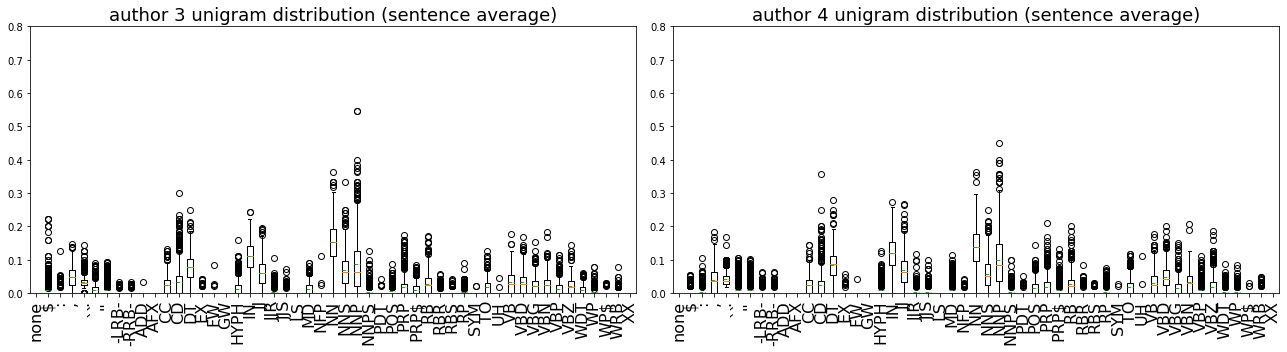

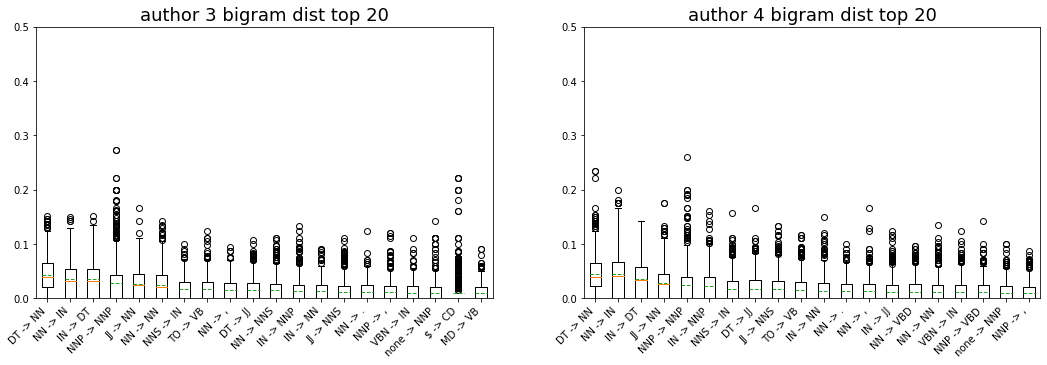

In [ ]:
# author 2, 3
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.boxplot(np.array(unigram_dist[0]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=90, fontsize=16)
plt.title('author 3 unigram distribution (sentence average)', fontsize=18)
plt.ylim(0,0.8)
plt.subplot(1,2,2)
plt.boxplot(np.array(unigram_dist[1]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=90, fontsize=16)
plt.title('author 4 unigram distribution (sentence average)', fontsize=18)
plt.ylim(0,0.8)
plt.tight_layout()
plt.show()

# author 2, 3
top_n = 20
curr, prev = np.meshgrid(xpos_vocab, xpos_vocab)
prev = prev.reshape(-1)
curr = curr.reshape(-1)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist[0]).reshape(len(bigram_dist[0]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 3 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.subplot(1,2,2)
bigram_dist_reshaped = np.array(bigram_dist[1]).reshape(len(bigram_dist[1]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 4 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.show()

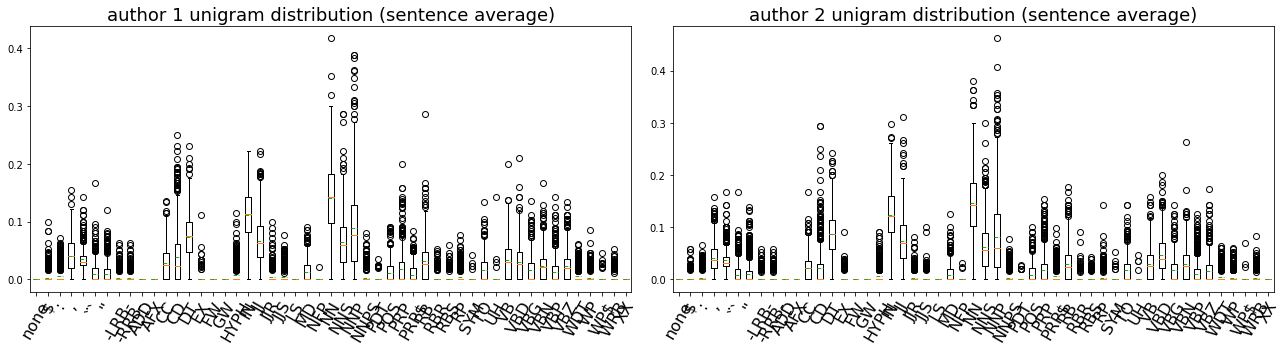

In [ ]:
# author 0, 1
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.boxplot(np.array(unigram_dist[0]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('author 1 unigram distribution (sentence average)', fontsize=18)
plt.subplot(1,2,2)
plt.boxplot(np.array(unigram_dist[1]), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('author 2 unigram distribution (sentence average)', fontsize=18)
plt.tight_layout()
plt.show()

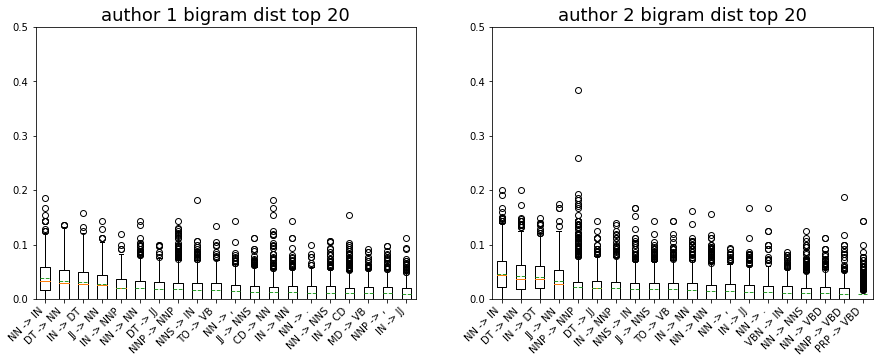

In [ ]:
# author 0, 1
top_n = 20
curr, prev = np.meshgrid(xpos_vocab, xpos_vocab)
prev = prev.reshape(-1)
curr = curr.reshape(-1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist[0]).reshape(len(bigram_dist[0]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 1 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.subplot(1,2,2)
bigram_dist_reshaped = np.array(bigram_dist[1]).reshape(len(bigram_dist[1]),-1)
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'author 2 bigram dist top {top_n}', fontsize=18)
plt.ylim(0,0.5)

plt.show()

In [ ]:
# all avaiable functions
['textstat.avg_character_per_word',
 'textstat.avg_letter_per_word',
 'textstat.avg_sentence_length',
 'textstat.avg_sentence_per_word',
 'textstat.avg_syllables_per_word',
 'textstat.char_count',
 'textstat.coleman_liau_index',
 'textstat.count_arabic_long_words',
 'textstat.count_arabic_syllables',
 'textstat.count_complex_arabic_words',
 'textstat.count_faseeh',
 'textstat.crawford',
 'textstat.dale_chall_readability_score',
 'textstat.dale_chall_readability_score_v2',
 'textstat.difficult_words',
 'textstat.difficult_words_list',
 'textstat.fernandez_huerta',
 'textstat.flesch_kincaid_grade',
 'textstat.flesch_reading_ease',
 'textstat.gulpease_index',
 'textstat.gunning_fog',
 'textstat.gutierrez_polini',
 'textstat.is_difficult_word',
 'textstat.is_easy_word',
 'textstat.letter_count',
 'textstat.lexicon_count',
 'textstat.linsear_write_formula']

In [ ]:
def run_textstat(sentence):
    res = {}
    res1 = {}
    res2 = {}
    res1['avg_letter_per_word'] = textstat.avg_letter_per_word(sentence)
    res1['avg_syllables_per_word'] = textstat.avg_syllables_per_word(sentence)    
    res['sentence_length'] = textstat.avg_sentence_length(sentence)    
    res['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(sentence) 
    
    # counts
    res['difficult_words'] = textstat.difficult_words(sentence)    
    res['polysyllabcount'] = textstat.polysyllabcount(sentence) # num syllable >= 3
    res['monosyllabcount'] = textstat.monosyllabcount(sentence) # num syllable == 1
    res['syllable_count'] = textstat.syllable_count(sentence) # total syllable in a sentence
    res['syllable_count'] = textstat.syllable_count(sentence)
    
    # these two stats are much larger than others
    res2['char_count'] = textstat.char_count(sentence)
    res2['letter_count'] = textstat.letter_count(sentence)
    
    res['punc_count'] = res2['char_count'] - res2['letter_count']
    return res, res1, res2

In [ ]:
save_folder = '../../data/CCAT50/processed/'
picked_author_ids = [2,3]
num_sent_per_text = 1
df, file_name = create_dataset(df_ccat, picked_author_ids = picked_author_ids, num_sent_per_text = num_sent_per_text, save_folder = save_folder)
le = preprocessing.LabelEncoder()
le.fit(df['author'])
train_dataset = Dataset.from_csv(f'{save_folder}/{file_name}').shuffle()
train_dataset = train_dataset.map(pos_tokenize, batched=True)


In [ ]:

stats_by_author1 = [[],[]]
stats_by_author2 = [[],[]]
stats_by_author3 = [[],[]]

for x in tqdm(train_dataset):
    sentence = x['text']
    author = x['author']
    author -= 2
    res1, res2, res3 = run_textstat(sentence)
    stats_by_author1[author].append(list(res1.values()))
    stats_by_author2[author].append(list(res2.values()))   
    stats_by_author3[author].append(list(res3.values()))        

  0%|          | 0/1381 [00:00<?, ?it/s]

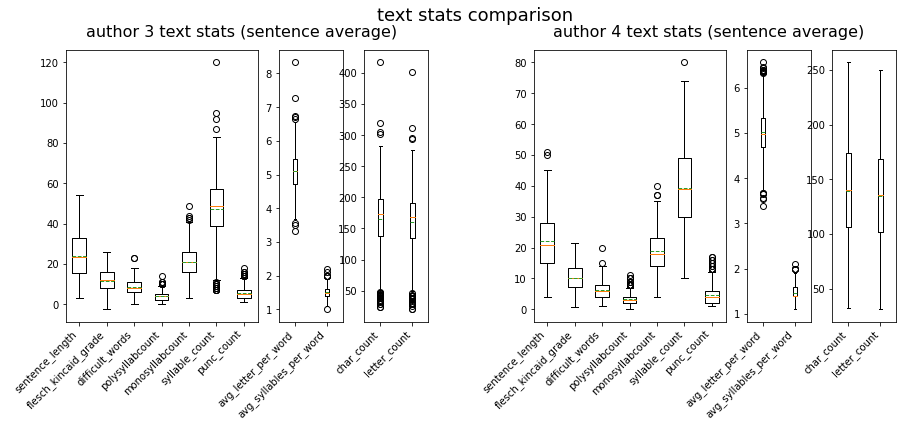

In [ ]:
# author 2, 3

f = plt.figure(figsize=(13,5)) # constrained_layout=True
# plt.subplots_adjust(top=1.5,hspace=0.4)
subfigs = f.subfigures(1, 2, wspace=0., hspace=0.)

(a0, a1, a2) = subfigs[0].subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 1]})
xticks = list(res1.keys())
a0.boxplot(np.array(stats_by_author1[0]), meanline=True, showmeans=True)
a0.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res2.keys())
a1.boxplot(np.array(stats_by_author2[0]), meanline=True, showmeans=True)
a1.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res3.keys())
a2.boxplot(np.array(stats_by_author3[0]), meanline=True, showmeans=True)
a2.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

(a0, a1, a2) = subfigs[1].subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 1]})
xticks = list(res1.keys())
a0.boxplot(np.array(stats_by_author1[1]), meanline=True, showmeans=True)
a0.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res2.keys())
a1.boxplot(np.array(stats_by_author2[1]), meanline=True, showmeans=True)
a1.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res3.keys())
a2.boxplot(np.array(stats_by_author3[1]), meanline=True, showmeans=True)
a2.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

# subfigs[0].set_facecolor('0.85')
# subfigs[1].set_facecolor('0.85')
subfigs[0].suptitle('author 3 text stats (sentence average)', y=0.95, fontsize = 16)
subfigs[1].suptitle('author 4 text stats (sentence average)', y=0.95, fontsize = 16)
f.suptitle('text stats comparison',y = 1,fontsize = 18) 
plt.show()

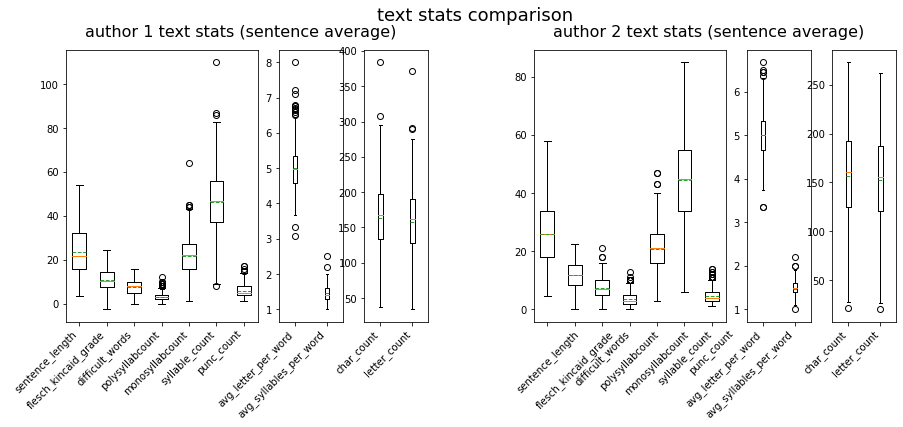

In [ ]:
# author 0, 1

f = plt.figure(figsize=(13,5)) # constrained_layout=True
# plt.subplots_adjust(top=1.5,hspace=0.4)
subfigs = f.subfigures(1, 2, wspace=0., hspace=0.)

(a0, a1, a2) = subfigs[0].subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 1]})
xticks = list(res1.keys())
a0.boxplot(np.array(stats_by_author1[0]), meanline=True, showmeans=True)
a0.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res2.keys())
a1.boxplot(np.array(stats_by_author2[0]), meanline=True, showmeans=True)
a1.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res3.keys())
a2.boxplot(np.array(stats_by_author3[0]), meanline=True, showmeans=True)
a2.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

(a0, a1, a2) = subfigs[1].subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 1]})
xticks = list(res1.keys())
a0.boxplot(np.array(stats_by_author1[1]), meanline=True, showmeans=True)
a0.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res2.keys())
a1.boxplot(np.array(stats_by_author2[1]), meanline=True, showmeans=True)
a1.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

xticks = list(res3.keys())
a2.boxplot(np.array(stats_by_author3[1]), meanline=True, showmeans=True)
a2.set_xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')

# subfigs[0].set_facecolor('0.85')
# subfigs[1].set_facecolor('0.85')
subfigs[0].suptitle('author 1 text stats (sentence average)', y=0.95, fontsize = 16)
subfigs[1].suptitle('author 2 text stats (sentence average)', y=0.95, fontsize = 16)
f.suptitle('text stats comparison',y = 1,fontsize = 18) 
plt.show()

## imdb

In [ ]:
epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/imdb/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

checkpoint = '/scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, local_files_only=True)

IDS = [[0,1]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [1e-3]
FREEZE_BERT = [False,0,1,2,3] # 0 still freezes the embedding layer. False freezes nothing.
REPEAT = list(range(5))

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert,repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, local_files_only=True, num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)  
    
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    if save:
        wconfig['model_folder'] = model_folder
    
    
    run = wandb.init(project="POS Bert imdb (best)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True,
                     settings=wandb.Settings(start_method="thread")
                    )
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        # save best model
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
        wandb.log({f'best_{monitering_metric}': best_metric})
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/25 [00:00<?, ?it/s]

Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▅▇▇▇▇▇▇█▇▇████▇██████████████████████
best_accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
f1,▁▅▇▆█▇██████▇███████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91289
best_accuracy,0.91289
f1,0.8681
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▅▆▆▆▇▇▇▇▇██▇█▇█████████████▇███████████
best_accuracy,▁▅▆▆▆▇▇▇▇▇██████████████████████████████
f1,▁▆▇▇▇█▇█▇█████▇█████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90408
best_accuracy,0.90767
f1,0.85245
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▅▆▆▇▆▇▇▇▇▇▇█▇▇███████▇█████████████████
best_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████████████████████████
f1,▁▆▇▇█▇▇██▇▇██▇██████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91191
best_accuracy,0.91517
f1,0.86608
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▇▆▇█▇▇█▇▇█▇▇█████████████████████████
best_accuracy,▁▄▆▇▇▇██████████████████████████████████
f1,▁▆▇▇▇███▇███████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90799
best_accuracy,0.91223
f1,0.86029
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▇▇▇█▇▇█▇▇██▇████████████████████████
best_accuracy,▁▄▆▆▇▇▇█████████████████████████████████
f1,▁▆▇▇██▇█▇▇██▇██▇████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90212
best_accuracy,0.90995
f1,0.84944
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▆▆▇▇▇▇█▇▇▇▇████▇████████████████████
best_accuracy,▁▄▆▆▆▆▇▇▇▇██████████████████████████████
f1,▁▆▆▇▇▇▇▇▇██▇█▇█████▇████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.9031
best_accuracy,0.90538
f1,0.85277
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇█▇████████▇▇████████
best_accuracy,▁▄▆▆▆▆▇▇▇▇▇▇████████████████████████████
f1,▁▆▇▇▇▆▇▇▇▇▇▇████▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91158
best_accuracy,0.91419
f1,0.86689
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▃▅▆▆▇▇▇▇▇▇█▇▇█████▇██▇████▇████████████
best_accuracy,▁▃▅▆▇▇▇▇▇▇▇█████████████████████████████
f1,▁▆▅▇▇▇███▇██████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90734
best_accuracy,0.91028
f1,0.8609
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▇▇▇▇▇▇▇▇█▇▇██████████████████████████
best_accuracy,▁▄▆▆▇▇▇▇▇▇▇█████████████████████████████
f1,▁▆▇▇████▇▇██▇███████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90375
best_accuracy,0.90604
f1,0.85239
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▇▇▇▇▇▇████▇█▇███████████████████████
best_accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
f1,▁▆▇▇▇▇▇███████▇█▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90734
best_accuracy,0.90799
f1,0.85713
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▆▇▇▇▇▇▇█▇▇█▇▇█▇▇██▇█▇███████████████
best_accuracy,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
f1,▁▆▇▇▇▇▇▇████████▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91582
best_accuracy,0.9168
f1,0.87291
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▆▇▇▇▆▇█▇▇████▇████████▇█████████████
best_accuracy,▁▄▆▆▆▇▇▇▇▇██████████████████████████████
f1,▁▆▇▇▇▇▇▇▇███████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90799
best_accuracy,0.91093
f1,0.85831
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▇▆▇▇█▇▇▇██▇███▇█████████████████████
best_accuracy,▁▄▆▆▇▇▇▇████████████████████████████████
f1,▁▆▇▇▇▇▇▇████████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.9106
best_accuracy,0.91289
f1,0.86565
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▆▆▆▆▆▇▇▇▇▇▇█▇████████▇████████████████
best_accuracy,▁▄▆▆▆▆▆▇▇▇▇▇▇███████████████████████████
f1,▁▆▇▆▇▇▇▇▇▇█▇████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91158
best_accuracy,0.91256
f1,0.86456
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▅▆▆▇▇▇▇▇▇▇████▇████████████████████████
best_accuracy,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
f1,▁▆▇▇▇▇▇▇▇███████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90832
best_accuracy,0.91126
f1,0.85989
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇█████████████████████
best_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████████████████████████
f1,▁▆▆▆▇▇▇▇▇▇▇█████▇█▇█████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90538
best_accuracy,0.90669
f1,0.85341
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇██▇▇██▇██▇███████████████
best_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
f1,▁▅▇▇▆▇▇█▇▇██▇▇██████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90701
best_accuracy,0.91126
f1,0.8548
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▅▅▆▆▇▇▆▇▇▇▇▇█▇▇▇███▇█▇▇██▇████████████
best_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇██████████████████████████
f1,▁▅▇▆▇▇▇█▇▇█▇▇▇██▇███████▇██▇████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90506
best_accuracy,0.9093
f1,0.85192
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█▇▇██████████████████████
best_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
f1,▁▅▇▆▇▇▇▇▇███████▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.90799
best_accuracy,0.9106
f1,0.85898
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████▇███▇██████████████
best_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇████████████████████████████
f1,▁▆▆▇▇▇▇▇▇▇█████▇████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.91191
best_accuracy,0.91223
f1,0.86369
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▃▅▆▆▆▅▆▇▇▇▇▇▇▇▇▇▇███████▇██▇▇██████████
best_accuracy,▁▃▅▆▆▆▆▆▇▇▇▇▇▇██████████████████████████
f1,▁▄▆▇▆▆▇▇▇▇▇▇▇▇▇█▇███████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.8721
best_accuracy,0.87276
f1,0.79691
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▂▅▆▆▆▇▇▇▇▇▇▇▇█▇█████▇▇██▇▇█████████████
best_accuracy,▁▂▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
f1,▁▃▆▇▇▇▇▇█▇▇██▇███████████▇██████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.86688
best_accuracy,0.87047
f1,0.78366
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███▇██████████████
best_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
f1,▁▄▆▆▆▇▇▇█▇▇█▇█▇█▇█▇█▇███████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.87341
best_accuracy,0.877
f1,0.79949
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▂▄▅▆▆▆▇▆▇▇▅▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇████████████
best_accuracy,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
f1,▁▃▅▇▆▇▇█▇▇▇▆███▇▇▇██████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.87504
best_accuracy,0.87765
f1,0.7989
global_step,17280


Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_corenlp/retrained_pos_mlm_1/checkpoint-155000/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▂▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇███▇██▇██████
best_accuracy,▁▂▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
f1,▁▃▆▆▇▇▇▇▇██▇████▇▇██████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.87537
best_accuracy,0.87765
f1,0.80284
global_step,17280


# bert 

In [ ]:
def bert_collate_fn(batch):
    batch_out = {}
    text = []
    labels = []
    for sample in batch:
        text.append(sample['text'])
        labels.append(sample['author'])
        
    batch_out.update({k:v for k,v in tokenizer(text = text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device).items()})
    batch_out.update({'labels': torch.LongTensor(labels).to(device)})
    return batch_out

## CCAT50

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/CCAT50/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

IDS = [[0,1]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [5e-5]
FREEZE_BERT = [10,True] 
REPEAT = list(range(5))

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert,repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    
    
    run = wandb.init(project="Bert CCAT (best)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True, 
                     settings=wandb.Settings(start_method="thread")
                    )
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
        wandb.log({f'best_{monitering_metric}': best_metric})
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2460 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


accuracy,▁███████████████████████████████████████
best_accuracy,▁███████████████████████████████████████
f1,▁███████████████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.99394
best_accuracy,0.99697
f1,0.99392
global_step,2460


KeyboardInterrupt: 

## imdb

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/imdb/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

IDS = [[0,1]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [5e-5]
FREEZE_BERT = [10,True] 
REPEAT = list(range(5))

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert,repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    str_author = ','.join(map(str, ids))
    file = f"author_{str_author}_sent_{num_sentences}_train.csv"
    df = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df[col] = df[col].apply(ast.literal_eval)
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_training_steps = len(train_loader)
    
    file = f"author_{str_author}_sent_{num_sentences}_val.csv"
    df_val = pd.read_csv(f'{data_folder}/{file}')
    for col in cols_to_eval:
        df_val[col] = df_val[col].apply(ast.literal_eval)
    df_val = preprocess_author_ids(df_val)
    val_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_valid_steps = len(valid_loader)
    
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    
    
    run = wandb.init(project="Bert imdb (best)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True, 
                     settings=wandb.Settings(start_method="thread")
                    )
    
    best_metric = 0.0
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        model.eval()
        acc = evaluate.load('accuracy')
        f1 = evaluate.load('f1')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
            f1.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        evaluation = acc.compute()
        evaluation.update(f1.compute(average='macro'))
        evaluation.update({'global_step':pbar.n})
        wandb.log(evaluation, step=pbar.n)
        
        if (best_metric < evaluation[monitering_metric]):
            best_metric = evaluation[monitering_metric]
        wandb.log({f'best_{monitering_metric}': best_metric})
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

accuracy,▁▇▇▇█▇███▇████████▇█████████████████████
best_accuracy,▁▇▇▇████████████████████████████████████
f1,▁▇██████████████████████████████████████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.97096
best_accuracy,0.97423
f1,0.95743
global_step,17280


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/17280 [00:00<?, ?it/s]

KeyboardInterrupt: 

## guardian - topic confusion

In [ ]:
cols_to_eval = ['homo_edges', 'hetoro_edges', 'pos_seqs', 'upos_seqs', 'num_syllables']

str_topic='0,1'
str_author='0,1'
num_sent_per_text = 2

split = 'train'
filename = f"topic_{str_topic}_author_{str_author}_sent_{num_sent_per_text}_{split}.csv"
file = f'../../data/guardian/processed/{filename}'
df = pd.read_csv(file)
for col in cols_to_eval:
    df[col] = df[col].apply(ast.literal_eval)

split = 'val'
filename = f"topic_{str_topic}_author_{str_author}_sent_{num_sent_per_text}_{split}.csv"
file = f'../../data/guardian/processed/{filename}'
df_val = pd.read_csv(file)
for col in cols_to_eval:
    df_val[col] = df_val[col].apply(ast.literal_eval)
    
split = 'test'
filename = f"topic_{str_topic}_author_{str_author}_sent_{num_sent_per_text}_{split}.csv"
file = f'../../data/guardian/processed/{filename}'
df_test = pd.read_csv(file)
for col in cols_to_eval:
    df_test[col] = df_test[col].apply(ast.literal_eval)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

epochs = 60
batchsize = 32
num_labels = 2
data_folder = '../../data/imdb/processed'
monitering_metric = 'accuracy'
warmup_ratio = 0.15 
save = False

IDS = [[0,1]]
NUM_SENTENCES = [2]
LIMIT = [None]
LR = [5e-5]
FREEZE_BERT = [10,True] 
REPEAT = list(range(5))

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)

num_runs = len(list(ARGS))
run_pbar = trange(num_runs, leave=False)

ARGS = itertools.product(IDS, NUM_SENTENCES, LIMIT, LR, FREEZE_BERT, REPEAT)
for i_run, args in enumerate(ARGS):
    ids, num_sentences, limit, lr, freeze_bert,repeat = args
    
    seed = int(datetime.now().timestamp())
    set_seed(seed)
    
    # data
    df = preprocess_author_ids(df)
    train_dataset = Dataset.from_pandas(df).shuffle()
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_training_steps = len(train_loader)
    
    df_val = preprocess_author_ids(df_val)
    valid_dataset = Dataset.from_pandas(df_val).shuffle()
    valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_valid_steps = len(valid_loader)
    
    df_test = preprocess_author_ids(df_test)
    test_dataset = Dataset.from_pandas(df_test).shuffle()
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True, collate_fn=bert_collate_fn)
    num_test_steps = len(test_loader)
    
    # model
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(ids))
    model = freeze_model(model, freeze_bert)
    model = model.to(device)
    
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)

    scheduler = get_scheduler("linear",
                            optimizer=optimizer,
                            num_warmup_steps=int(warmup_ratio*epochs*num_training_steps),
                            num_training_steps=epochs*num_training_steps)
    # wandb config
    wconfig = {}
    wconfig['seed'] = seed
    wconfig['ids'] = ids
    wconfig['num_authors'] = len(ids)
    wconfig['num_sentences'] = num_sentences
    wconfig['lr'] = lr
    wconfig['freeze_bert'] = freeze_bert
    
    
    run = wandb.init(project="Bert guardian (best)", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'run_{i_run}',
                     reinit=True, 
                     settings=wandb.Settings(start_method="thread")
                    )
    
    best_evaluation = collections.defaultdict(float)
    pbar = trange(epochs*num_training_steps, leave=False)
    for i_epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = nested_to(data, device)
            optimizer.zero_grad()
            output = model(**data)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)
        
        # train acc
        model.eval()
        acc = evaluate.load('accuracy')
        for data in train_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        train_evaluation = acc.compute()
        
        # val acc
        model.eval()
        acc = evaluate.load('accuracy')
        for data in valid_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        val_evaluation = acc.compute()
        
        # test acc
        model.eval()
        acc = evaluate.load('accuracy')
        for data in test_loader:
            data = nested_to(data, device)
            output = model(**data)
            logit = output['logits']
            acc.add_batch(predictions=logit.argmax(axis=-1).cpu().detach().numpy(), references=data['labels'].cpu().numpy())
        test_evaluation = acc.compute()
        
        # logging
        evaluation = {'train_accuracy':train_evaluation['accuracy'], 'val_accuracy':val_evaluation['accuracy'], 'test_accuracy':test_evaluation['accuracy']}
        wandb.log(evaluation, step=pbar.n)
        for key in evaluation:
            best_evaluation[f'best_{key}'] = max(best_evaluation[f'best_{key}'], evaluation[key])
        wandb.log(best_evaluation, step=pbar.n)
        
    
    run.finish()
    run_pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▆▇████████████████████████████████████
best_train_accuracy,▁▁▇█████████████████████████████████████
best_val_accuracy,▁▁▅▆████████████████████████████████████
test_accuracy,▁▁▆▇████▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_accuracy,▁▁▇█████████████████████████████████████
val_accuracy,▁▁▅▆▇███▆▅▇▆▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇
best_test_accuracy,0.78571
best_train_accuracy,1.0
best_val_accuracy,0.80398
test_accuracy,0.73745
train_accuracy,1.0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▄█████████████████████████████████████
best_train_accuracy,▁▁▆█████████████████████████████████████
best_val_accuracy,▁▁▄▇████████████████████████████████████
test_accuracy,▁▁▄█████████████████████████████████████
train_accuracy,▁▁▆█████████████████████████████████████
val_accuracy,▁▁▄▇███▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
best_test_accuracy,0.79537
best_train_accuracy,1.0
best_val_accuracy,0.81829
test_accuracy,0.76834
train_accuracy,1.0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▂▇████████████████████████████████████
best_train_accuracy,▁▅▆█████████████████████████████████████
best_val_accuracy,▁▂▃▇████████████████████████████████████
test_accuracy,▂▁▃▇▆█▇▇▇██▇▇▇▇▇██████▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇
train_accuracy,▁▅▆█████████████████████████████████████
val_accuracy,▁▂▄▇▆█▇▇▇▇▇▇▇▇▇▇██████▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
best_test_accuracy,0.79151
best_train_accuracy,1.0
best_val_accuracy,0.81083
test_accuracy,0.75676
train_accuracy,1.0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▅▇████████████████████████████████████
best_train_accuracy,▁▁▆█████████████████████████████████████
best_val_accuracy,▁▁▅▇████████████████████████████████████
test_accuracy,▁▁▅█▇█▇█▇█▇▇▇▇███▇▇██▇▇▇████▇▇█▇▇▇▇▇▇▇▇▇
train_accuracy,▁▁▆█████████████████████████████████████
val_accuracy,▁▁▅▇▇█▇█▇█▇▇▇▇██▇▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇
best_test_accuracy,0.79151
best_train_accuracy,1.0
best_val_accuracy,0.799
test_accuracy,0.74517
train_accuracy,1.0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▄▆▇▇██████████████████████████████████
best_train_accuracy,▁▂▆█████████████████████████████████████
best_val_accuracy,▁▁▄▆▇▇██████████████████████████████████
test_accuracy,▁▁▄▆▇▇██▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_accuracy,▁▂▆█████████████████████████████████████
val_accuracy,▁▁▄▆▇▇██▇▇▇█▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇▇
best_test_accuracy,0.78958
best_train_accuracy,1.0
best_val_accuracy,0.80087
test_accuracy,0.76255
train_accuracy,1.0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_train_accuracy,▁▂██████████████████████████████████████
best_val_accuracy,▁▁██████████████████████████████████████
test_accuracy,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▁▂██████████████████████████████████████
val_accuracy,▃▁██████████████████████████████████████
best_test_accuracy,0.6332
best_train_accuracy,0.80922
best_val_accuracy,0.55258
test_accuracy,0.40734
train_accuracy,0.80922


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_train_accuracy,▁▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇████████████████
best_val_accuracy,▁▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
test_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_accuracy,▁▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇████████████▇▇▇▇
val_accuracy,▁▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇█████████████
best_test_accuracy,0.51158
best_train_accuracy,0.81399
best_val_accuracy,0.55694
test_accuracy,0.41892
train_accuracy,0.81081


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▅▅▅▆▆▇▇▇▇▇▇████████
best_train_accuracy,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▇▇▇▇▇▇████████
best_val_accuracy,▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇████████
test_accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▅▅▅▆▆▇▆▇▇▇▇████████
train_accuracy,▁▂▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▇▆▇▇▇▇██▇█▇▇▇▇
val_accuracy,▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▄▄▄▅▆▆▆▆▇▇▇████████
best_test_accuracy,0.4112
best_train_accuracy,0.81081
best_val_accuracy,0.55383
test_accuracy,0.4112
train_accuracy,0.80763


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁███████████████████████████████████████
best_train_accuracy,▁▁▇█████████████████████████████████████
best_val_accuracy,▁▂▇█████████████████████████████████████
test_accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_accuracy,▁▁▇█████████████████████████████████████
val_accuracy,▁▂▇█████████████████████████████████████
best_test_accuracy,0.64479
best_train_accuracy,0.80763
best_val_accuracy,0.55072
test_accuracy,0.40154
train_accuracy,0.80763


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1200 [00:00<?, ?it/s]

best_test_accuracy,▁███████████████████████████████████████
best_train_accuracy,▁▁▇█████████████████████████████████████
best_val_accuracy,▁▁▇█████████████████████████████████████
test_accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▇█████████████████████████████████████
val_accuracy,▁▁▇█████████████████████████████████████
best_test_accuracy,0.62934
best_train_accuracy,0.79968
best_val_accuracy,0.54885
test_accuracy,0.39575
train_accuracy,0.7965
